This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case. \

In [1]:
!pip uninstall -y jax

Found existing installation: jax 0.4.30
Uninstalling jax-0.4.30:
  Successfully uninstalled jax-0.4.30


In [1]:
!pip install jax

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%%capture
!pip install ../


Loading of the necessary modules

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flip import fitter, plot_utils, utils, vectors
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")
plt.style.use(os.path.join(data_path,"style.mplstyle"))

/home/ravoux/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[ 000000.00 ]: 07-25 18:20  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.00 ]: 07-25 18:20  root            WARNING  Install CLASS https://github.com/lesgourg/class_public to use class.py module


Loading the data, located in the package itself



In [3]:
data_velocity = pd.read_parquet(os.path.join(data_path, "velocity_data.parquet"))

data_velocity_true = {"velocity": data_velocity["vpec"].values, 
                      "velocity_error": np.zeros(len(data_velocity["vpec"].values))}

coordinates_velocity = np.array([data_velocity["ra"], 
                                 data_velocity["dec"], 
                                 data_velocity["rcom_zobs"]])

ktt, ptt = np.loadtxt(os.path.join(data_path, "power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path, "power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path, "power_spectrum_mm.txt"))

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


In [4]:
size_batch=10_000
number_worker=16


covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)


[ 000000.61 ]: 07-25 18:20  root            INFO     Covariance matrix generated from flip with carreres23 model in 4.53e-01 seconds


Second part of the flip package: compute the likelihood, and start the minuit fitter

In [5]:
covariance_fit.covariance_dict["vv"]

array([[291705.24465409,  32508.53974579,  59310.51642811, ...,
         24922.7417289 ,  16091.33602935,  11681.90957129]])

In [6]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "direct",
                         "use_jax": True,
                         "use_gradient": True}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }



minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_velocity_true,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


minuit_fitter.run()


[ 000000.71 ]: 07-25 18:20  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': 
[ 000000.71 ]: 07-25 18:20  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.71 ]: 07-25 18:20  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000002.93 ]: 07-25 18:20  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │         Nfcn = 44, Ngrad = 3         │
│ EDM = 0.000371 (Goal: 0.0002)    │            time = 2.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │

{'fs8': 0.3525466105012079, 'sigv': 199.55449553630925}

In [7]:
test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}

velocity, velocity_error = vectors.get_velocity_from_salt_fit(
    data_velocity,
    test_parameters,
    "full",
)

mask = np.abs(velocity) < 3_000
mask &= velocity_error < 3_000

coordinates_velocity_cleaned = np.transpose(np.transpose(coordinates_velocity)[mask])
data_velocity_cleaned = {}
for key in list(data_velocity.keys()):
    data_velocity_cleaned[key] = np.array(data_velocity[key])[mask]

In [8]:
coordinates_velocity_cleaned.shape

(3, 1667)

In [9]:
size_batch=10_000
number_worker=16


covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity_cleaned,
    size_batch=size_batch,
    number_worker=number_worker,
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000003.64 ]: 07-25 18:20  root            INFO     Covariance matrix generated from flip with carreres23 model in 4.47e-01 seconds


In [11]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "saltfit",
                         "velocity_estimator": "full",
                         "use_jax": True,
                         "use_gradient": True,
                        }


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "limit_up" : 1.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "limit_up" : 1000,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         }}

minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_velocity_cleaned,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


minuit_fitter_velest.run()


/home/ravoux/.local/lib/python3.10/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
[ 000024.41 ]: 07-25 18:20  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.415e+04                  │        Nfcn = 193, Ngrad = 9         │
│ EDM = 0.000479 (Goal: 0.0002)    │            time = 6.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│

{'fs8': 0.45641370041124896,
 'sigv': 590.7718484519008,
 'alpha': 0.1328596196322107,
 'beta': 3.0995834316706063,
 'M_0': -19.067436515997006,
 'sigma_M': 0.08628632805587404}

# Some plots

Plot of the latest covariance matrix computed 

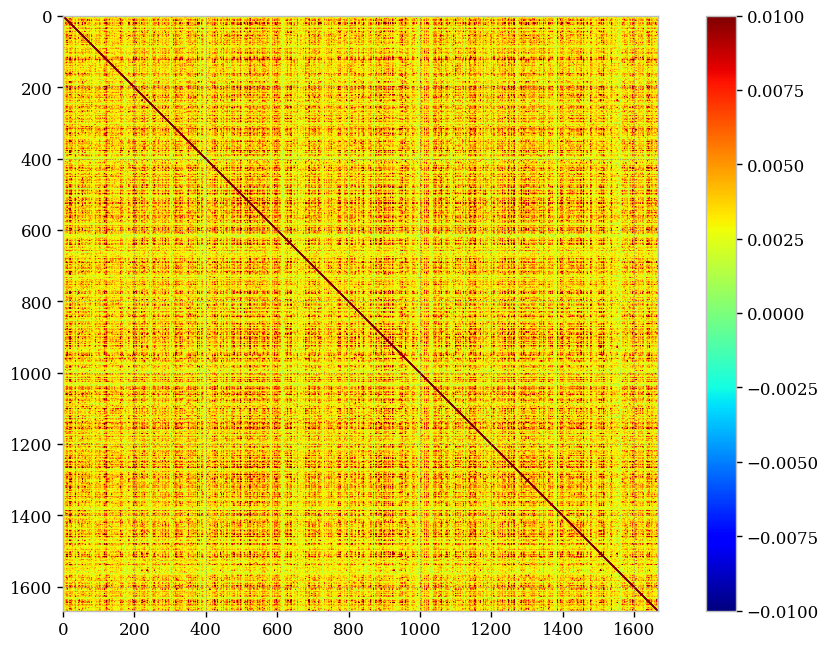

In [20]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter_velest.likelihood,
    parameter_dict,
    vmin=-0.01, vmax=0.01
)

The covariance matrix model can be contracted when we consider parallel and perpendicular separations. \
It allows to see the model more clearly:

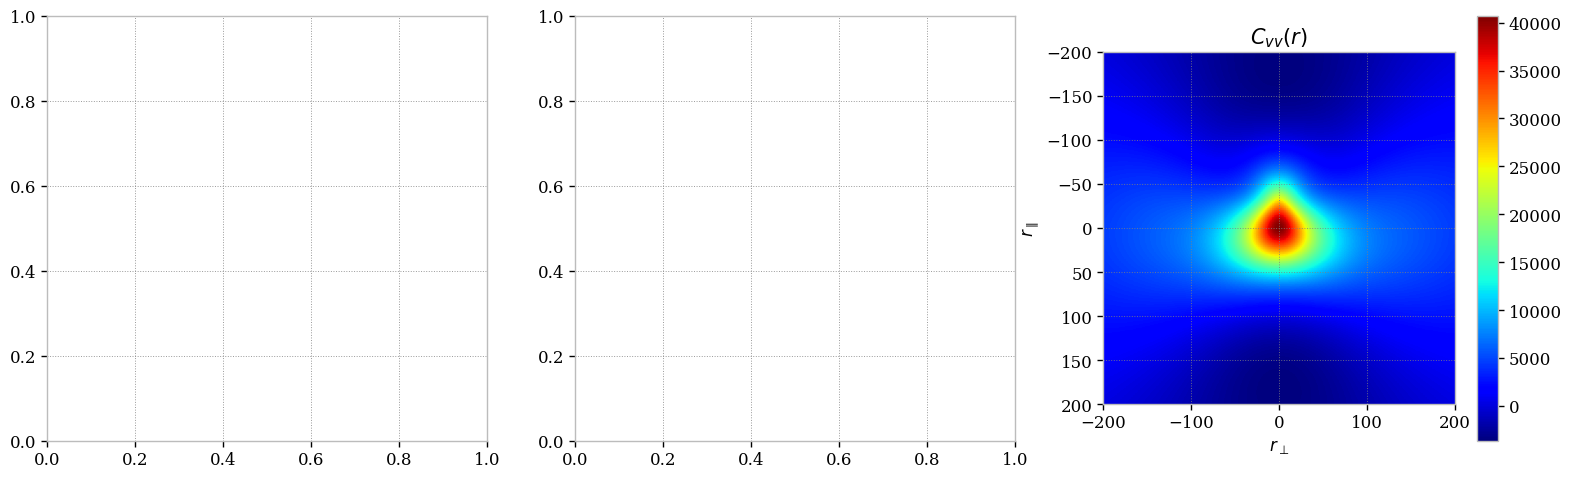

In [21]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)


# MCMC true vel fit

In [29]:
sn_data = pd.read_parquet(os.path.join(data_path, "velocity_data.parquet"))

# Removing bad fits
sn_data = sn_data[np.array(sn_data["status"]) != False]
sn_data = sn_data[np.array(sn_data["status"]) != None]

coordinates_velocity = np.array([sn_data["ra"], sn_data["dec"], sn_data["como_dist"]])

data_velocity = sn_data.to_dict("list")
for key in data_velocity.keys():
    data_velocity[key] = np.array(data_velocity[key])
data_velocity["velocity"] = data_velocity.pop("vpec")
data_velocity["velocity_error"] = np.zeros_like(data_velocity["velocity"])


ktt, ptt = np.loadtxt(os.path.join(data_path, "power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path, "power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path, "power_spectrum_mm.txt"))

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


In [30]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {
        "inversion_method": "cholesky",
        "velocity_type": "direct"
        }


parameter_dict = {
        "fs8": {
                "randfun": lambda size: np.random.normal(0.4, 0.001, size=size),
                },
        "sigv": {
                "randfun": lambda size: np.random.normal(200, 10, size=size),
                },
        }


In [31]:
size_batch=10_000
number_worker=16

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)

mcmc_fitter = fitter.FitMCMC.init_from_covariance(
        covariance_fit,
        data_velocity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        nwalkers=4
)


[ 000371.32 ]: 03-04 11:39  root            INFO     Covariance matrix generated from flip with carreres23 model in 8.88e-01 seconds


In [32]:
sampler = mcmc_fitter.sampler.run_chains(10)

In [34]:
sampler.chain

array([[[  0.40269977, 201.88200261],
        [  0.40187965, 206.69923217],
        [  0.40187965, 206.69923217],
        [  0.40187965, 206.69923217],
        [  0.40187965, 206.69923217],
        [  0.40063636, 245.07024403],
        [  0.40009463, 261.78937169],
        [  0.40007068, 270.05158479],
        [  0.40007068, 270.05158479],
        [  0.40007068, 270.05158479]],

       [[  0.40010242, 197.41865658],
        [  0.40024764, 203.20871476],
        [  0.40024764, 203.20871476],
        [  0.40024764, 203.20871476],
        [  0.40022464, 208.63334256],
        [  0.40021446, 211.03613895],
        [  0.400135  , 229.77839668],
        [  0.39970818, 255.73078434],
        [  0.39970818, 255.73078434],
        [  0.39969017, 256.77191303]],

       [[  0.40052844, 214.63592224],
        [  0.39999258, 217.7834912 ],
        [  0.39994347, 220.58918172],
        [  0.4000425 , 246.07685757],
        [  0.39994335, 266.45817926],
        [  0.3991075 , 292.25455115],
        